Trying to estimate systematic miscalibration in Metaculus' community prediction for continuous questions. I'm following these steps:

1. Pull all continuous questions that resolved non-ambiguously from main domain API, save them to json.
2. Load this json, fit true CDF to community CDF using isotonic regression (see [here](https://arxiv.org/abs/1807.00263) for motivation), pickle model.
3. Pull questions I want to predict using ergo, recalibrate community prediction using fitted model, submit recalibrated distribution.

## TODO
1. Check this approach works before submitting! Use train/test split or crossvalidate or something. You'll need to code Metaculus' reward function by hand.

In [24]:
import os, json, pickle, urllib, time
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['figure.figsize'] = 1.5 * np.array([16.0, 9.0])
# matplotlib.rcParams['font.fontsize'] = 22

import seaborn as sns

from sklearn.isotonic import IsotonicRegression

import ergo

from KEYS import USERNAME, PASSWORD

# Parameters

In [2]:
questions_path = "db/training_questions.json"
calibration_data_path = "db/calibration_data.npy"
model_path = "db/ir_model.pkl"
search_queries = [
    "series--maximum-likelihood",
    "series--hill-climbing",
]
# 20 qs/page, so this assumes <40 questions per round, in line with the "approximately 30" stated in the rules
# change accordingly if it fails
N_PAGES = 2

# kinda slow but it's worth it
N_SAMPLES = int(10e3)

In [3]:
DOWNLOAD_QS = not os.path.isfile(questions_path)
BUILD_DATASET = not os.path.isfile(calibration_data_path)
FIT_MODEL = not os.path.isfile(model_path)

# 1. Dataset building

In [4]:
def download_questions(
    fpath,
    url = "https://www.metaculus.com/api2/questions/",
    sleep_secs=2,
    filter_=None,
    verbose=True
    ):

    to_save = []
    
    if filter_ is None:
        filter_ = lambda _: True

    while True:
        if verbose:
            print(f"Downloading questions from {url}")

        with urllib.request.urlopen(url) as f:
            data = json.load(f)
        
        for question in data['results']:
            if filter_(question):
                to_save.append(question)
        
        if data['next'] is not None:
            url = data['next']
            time.sleep(sleep_secs)
        else:
            break

    with open(fpath, 'w') as f:
        if verbose:
            print(f"Saving questions to {fpath}")
        # dumping a list - is this a good idea in general?
        json.dump(to_save, f)

    if verbose: print("\nDone!")

def json_load(fpath):
    with open(fpath, 'r') as f:
        d = json.load(f)
    return d

is_continuous = lambda q: q['possibilities']['type'] == 'continuous'
resolved_ok = lambda q: q['resolution'] not in (None, -1)
training_q = lambda q: is_continuous(q) and resolved_ok(q)

def get_histogram(question):
    """Metaculus and community pdfs over normalized range."""
    h = pd.DataFrame(question['prediction_histogram'])
    h.columns = ['x', 'm', 'c']
    return h

def F_star(question):
    """CDF evaluated at resolution"""
    h = get_histogram(question)
    return h[h['x'] <= question['resolution']]['c'].sum() / h.shape[0]

def P_hat(questions):
    """Empirical probability that resolution is indeed below CDF_community(resolution)"""
    return lambda p: len([q for q in (questions.values() if isinstance(questions, dict) else questions) if F_star(q) <= p]) / len(questions)

def calibration_dataset(questions):
    """Generate pairs (CDF_community(resolution), empirical_prob(resolution <= CDF_community(resolution)) to run regression on"""
    d = []
    p_hat = P_hat(questions)
    for q in (questions.values() if isinstance(questions, dict) else questions):
        try:
            fstar = F_star(q)
            d.append((fstar, p_hat(fstar)))
        except Exception as e:
            print(f"Could not add question {q['id']} to calibration dataset")
            print(e)
    return d

def build_dataset(questions_path, save_path, filter_=None):
    if filter_ is None:
        filter_ = lambda _: True
    qs = json_load(questions_path)
    d = calibration_dataset([q for q in qs if filter_(q)])
    # with open(save_path, 'w') as f:
    np.save(save_path, d)

# 2. Model fitting

In [5]:
def fit_model(calibration_data, oob='clip'):
    df = pd.DataFrame(calibration_data, columns=['x', 'y'])
    ir = IsotonicRegression(
        y_min=0,
        y_max=1,
        increasing=True,
        out_of_bounds=oob).fit(df['x'], df['y'])
    return ir

def build_model(calibration_path, save_path, oob='clip'):
    # with open(calibration_path, 'r') as f:
    cdata = np.load(calibration_path)
    ir = fit_model(cdata, oob=oob)
    with open(save_path, 'wb') as f:
        pickle.dump(ir, f, protocol=pickle.HIGHEST_PROTOCOL)

# 3. Pulling and recalibrating new questions

In [32]:
def fetch_and_submit(
    search_query=search_queries,
    model_path=model_path,
    username=USERNAME,
    password=PASSWORD,
    n_pages=N_PAGES,
    n_samples=N_SAMPLES,
    verbose=True,
):

    with open(model_path, 'rb') as f:
        ir = pickle.load(f)

    qs = fetch_questions(search_query, username, password, n_pages)

    for q in qs:
        if verbose:
            print(f"{q.id}: {q.name}")
        try:
            submit_recalibrated(q, ir, n_samples=N_SAMPLES)
        except Exception as e:
            print(e)
            continue

    if verbose: print("\nDone!")

def recalibrate_question(ergo_q, fitted_ir):
    # save old histogram in question - you're gonna overwrite it later and don't wanna lose it
    setattr(ergo_q, 'community_histogram', ergo_q.data['prediction_histogram'])
    h = get_histogram(ergo_q.data)
    interpolate = lambda x: [(x0 + x1) / 2 for x0, x1 in zip(x[:-1], x[1:])]
    pdf = [ergo_q.p_below] + h['c'].tolist() + [ergo_q.p_above]
    dx = 1 / (h.shape[0] - 1)
    cdf = np.cumsum(pdf)*dx
    new_cdf = fitted_ir.predict(cdf)
    new_pdf = interpolate(np.diff(new_cdf) / dx) # assumes p_below (p_above) concentrated in -dx (1+dx)
    # h_new = np.array([h['x'].values, h['m'].values, new_pdf]).T.tolist()
    h['c'] = new_pdf
    ergo_q.set_data('prediction_histogram', h.values.tolist())
    return ergo_q

def fetch_questions(search_query, username=USERNAME, password=PASSWORD, n_pages=N_PAGES):
    metaculus = ergo.Metaculus()
    metaculus.login_via_username_and_password(
        username=username,
        password=password
    )
    qs = []
    for cat in search_query:
        qs.extend(metaculus.get_questions(cat=cat, pages=n_pages))
    return qs

def submit_recalibrated(q, fitted_ir, n_samples=N_SAMPLES):
    new_q = recalibrate_question(q, fitted_ir)
    # TODO this is really dumb and inefficient - im sure ergo rebuilds the cdf under the hood
    # you should be able to fit it to a logistic mixture directly
    samples = np.array([new_q.sample_community() for _ in range(n_samples)])
    new_q.submit_from_samples(samples)

# 4. Run the whole thing

In [27]:
if DOWNLOAD_QS:
    download_questions(
    fpath=questions_path,
    url = "https://www.metaculus.com/api2/questions/",
    sleep_secs=2,
    filter_=training_q,
    verbose=True
    )

In [28]:
if BUILD_DATASET:
    build_dataset(questions_path, calibration_data_path, filter_=training_q)

In [29]:
if FIT_MODEL:
    build_model(calibration_data_path, model_path, oob='clip')

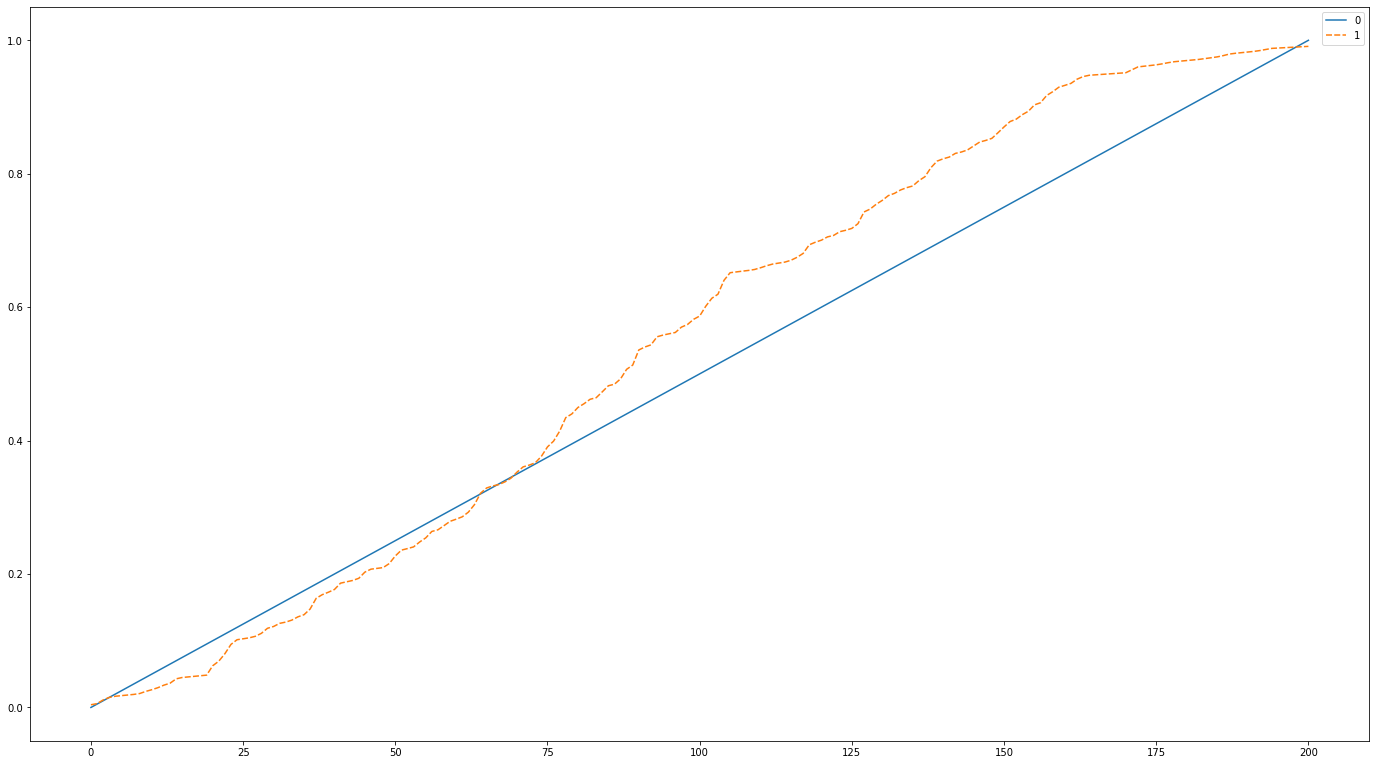

In [30]:
# Check model
with open(model_path, 'rb') as f:
    ir = pickle.load(f)

# Nice and clean correlation, but far from perfect -> edge possible!
uncalibrated_ps = np.linspace(0,1,201)
calibrated_ps = ir.predict(uncalibrated_ps)
sns.lineplot(data=[uncalibrated_ps, calibrated_ps])

In [33]:
fetch_and_submit()

5939: What percent will software and information services contribute to US GDP in Q1 of 2021?
5958: What percent will software and information services contribute to US GDP in Q4 of 2030?
5888: How many Computer Vision and Pattern Recognition e-prints will be published on arXiv over the 2020-12-14 to 2021-06-14 period?
5951: What will the average top price performance (in G3D Mark /$) of the best available GPU be, on December 14, 2026?
5960: What will the Federal Reserves' Industrial Production Index be for December 2026, for semiconductors, printed circuit boards and related products?
5961: How many Reinforcement Learning e-prints will be published on arXiv over the 2020-12-14 to 2031-01-01 period?
5965: What will the value of the herein defined Object Detection Performance Index be on 2021-06-14?
5901: How many Reinforcement Learning e-prints will be published on arXiv over the 2020-12-14 to 2021-06-14 period?
5897: What will the state-of-the-art performance on semantic segmentation 

# ~~ DEPRECATED ~~

In [21]:
# Load questions
# qs = remove_ambiguous(remove_noncont(json_load(fpath)))

In [22]:
# Generate regression dataset
# p_hat = P_hat(qs)
# cd = pd.DataFrame(calibration_dataset(qs), columns=['x', 'y'])

In [33]:
# Fit model
# TODO train/test split, cross-validation etc.
# cddf = pd.DataFrame(cd, columns=['x', 'y'])
# ir = IsotonicRegression(y_min=0, y_max=1, increasing=True, out_of_bounds='clip').fit(cddf['x'], cddf['y'])

In [ ]:
# simple rejection sampling, h/t https://stackoverflow.com/a/55772867
# def sample_cdf(x0, x1, cdf, n_samples=None, max_loops=10**6):
#     # TODO maybe I can replace this with ergo code and it'd be faster?
#     # they have to use the histogram somehow and build the community distribution from that...
#     samples = []
#     n_loops = 0
#     while len(samples) < n_samples and n_loops < max_loops:
#         x = np.random.uniform(low=x0, high=x1)
#         p = cdf(x)
#         assert 0 <= p <= 1
#         if np.random.uniform(low=0, high=1) <= p:
#             samples.append(x)
#         n_loops += 1
#     return samples

# def calibrated_samples(fitted_ir, question, n_samples=int(10e3), max_loops=int(1e6)):
#     # TODO check if ergo wants (un)normalized samples!!!
#     unc_cdf = get_histogram(question) # TODO cumsum in 'm', 'c' but not 'x'
#     cal_cdf = fitted_ir.predict(unc_cdf['c'])
#     def lmbd_cal_cdf(x):
#         pass # interpolate p(x) from closest upper/lower bound
#     samples = random_custDist(0, 1, lmbd_cal_cdf, n_samples=n_samples, max_loops=max_loops)

In [4]:
# qs = json_load(fpath)
# cqs = {k: v for k, v in qs.items() if is_continuous(v)}

In [30]:
# def get_range(question):
#     lo, hi = [question['possibilities']['scale'][k] for k in ('min', 'max')]
#     if isinstance(lo, str) and isinstance(hi, str): # date
#         lo, hi = map(pd.to_datetime, (lo, hi))
#     elif isinstance(lo, (int, float)) and isinstance(hi, (int, float)): # other
#         return (lo, hi)
#     else:
#         raise Exception(f"idk what to do with range ({lo}, {hi})")

# def get_bins(question):
#     if not is_continuous(question):
#         raise ValueError("Question must be continuous!")
#     lo, hi = get_range(question)
#     y = question['community_prediction']['full']['y']
#     n_bins = len(y)
#     rng = np.arange(lo, hi, (hi-lo)/n_bins)[1:]
#     assert len(rng) == n_bins
#     return (rng, y)
    # TODO I actually want to return bin edges and values
    # need to do a np.linspace for datetimes
    # return (rng, y)

# Bias

In [118]:
# df = pd.DataFrame([(k, v['community_prediction']['full'].get('q2'), v['resolution']) for k, v in cqs.items()]).dropna().reset_index().drop(columns='index')

In [119]:
# df.columns = ['qid', 'pred', 'res']
# df = df[df.res != -1].set_index('qid') # drop ambiguous

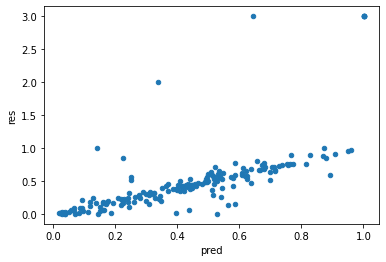

In [123]:
# df.plot.scatter('pred', 'res')

In [125]:
# from scipy.stats import linregress

In [130]:
# TODO this but bayesian
# linregress(df[df.res<=1].pred, df[df.res<=1].res)

LinregressResult(slope=0.9548159258998705, intercept=0.006997219675271504, rvalue=0.8537631690339177, pvalue=6.518336061468236e-51, stderr=0.04427052734150434)

In [186]:
# Resolution percentiles
# rps = [(q['resolution'], np.array(q['community_prediction']['full']['y'])) for k, q in cqs.items() if q['resolution'] not in (None, -1)]
# ps = []
# for (r, y) in rps:
#     ps.append(sum(y[:int(r*len(y))])/2) # 200 bins * 100%

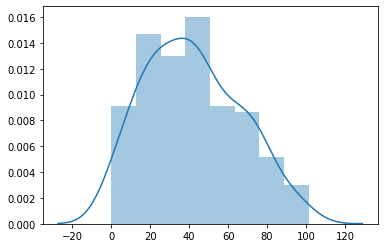

In [187]:
# resolution peaks at percentile ~40 => community distribution has bias towards higher values
# sns.distplot(ps)

# Underconfidence

In [195]:
# surprisal
# def surprisal(y, r):
#     integ = lambda x: sum(x) / 200 #len(x) if len(x)>0 else 0
#     if r > 1:
#         return integ(y[y > (1-integ(y)-y[0])])
#     else:
#         return integ(y[y > y[int(r*len(y))-1]])

# s = []
# for (r, y) in rps:
#     s.append(surprisal(y, r))

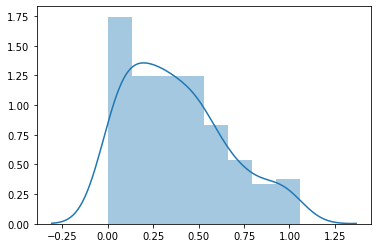

In [196]:
sns.distplot(s)

# Score maximization

In [197]:
# logN = lambda N: 20 * np.log2(1 + N / 30)
# A = lambda N: 40 + logN(N)
# B = lambda N: logN(N)

# def logit(x0, dx):
#     x_ = lambda x: (x-x0)/dx
#     return lambda x: np.exp(-x_) / (1 + np.exp(-x_))**2

# def P(x0s, dxs):
#     return lambda x: sum([logit(x0, dx)(x) for (x0, dx) in zip(x0s, dxs)])

# def S(N, Pc, P, closed=True):
#     Pu = 1/200 if closed else (1-.15)/200
#     return lambda x: A(N) * np.log(P(x) / Pu) + B(N) * np.log(P(x) / Pc(x))

# # TODO g(x) := Pr_emp [Pc(x_resolution) = x]

# def expected_score(S, g):
#     return sum([S(x) * g(x) for x in np.linspace(0, 1, 200)])

In [217]:
# g = []
# for qid, q in cqs.items():
#     x_star = q['resolution']
#     if x_star in (None, -1):
#         continue
#     h = pd.DataFrame(q['prediction_histogram'])
#     h.columns = ['x', 'm', 'c']
#     y0, y1 = h.iloc[(h['x'] - x_star).abs().argsort()[:2], :]['c'].sort_index()
#     # TODO different normalization if open!
#     g.append((y0 + y1)/2)

In [220]:
# np.log2(pd.Series(g)).describe()

count    182.000000
mean       2.140226
std        1.663122
min       -5.199563
25%        1.145994
50%        2.255709
75%        3.334572
max        5.020548
dtype: float64

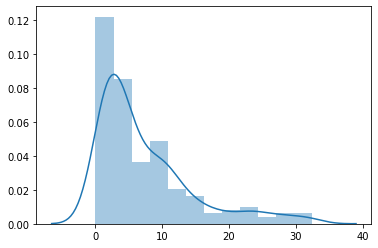

In [219]:
# sns.distplot(g)